In [0]:
import numpy,pandas,scipy,pylab,h5py,urllib,zipfile,time,warnings
from sklearn import datasets,preprocessing,impute,cluster,\
mixture,manifold,dummy,linear_model,svm
from sklearn.feature_extraction import DictVectorizer 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.decomposition import PCA; from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,median_absolute_error,\
mean_absolute_error,r2_score,explained_variance_score
from sklearn.metrics import accuracy_score,hamming_loss,classification_report
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier,\
DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,\
AdaBoostClassifier,GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,\
AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier,\
NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,\
QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor,\
GaussianProcessClassifier
from sklearn.gaussian_process.kernels import WhiteKernel,RationalQuadratic,RBF
from sklearn.semi_supervised import LabelPropagation,LabelSpreading
from sklearn.isotonic import IsotonicRegression
from sklearn.neural_network import MLPClassifier,BernoulliRBM,MLPRegressor

In [0]:
[warnings.filterwarnings('ignore',category=el) 
 for el in [UserWarning,FutureWarning,DeprecationWarning]]
numpy.set_printoptions(precision=4); pylab.style.use('seaborn-whitegrid')
style_dict={'background-color':'gainsboro','color':'darkslategray',
            'border-color':'white','font-family':'Roboto'}
def ohe(x): 
  return preprocessing.OneHotEncoder(categories='auto').fit(x.reshape(-1,1))\
  .transform(x.reshape(-1,1)).toarray().astype('int16')
def sas(X,y): return train_test_split(X,y,test_size=0.2,random_state=1)

# Data

internal datasets

In [3]:
boston=datasets.load_boston(); housing=datasets.fetch_california_housing()
digits=datasets.load_digits(); wine=datasets.load_wine();
faces=datasets.fetch_olivetti_faces()
[X1,y1,X2,y2,X3,y3,X4,y4,X5,y5]=\
[boston.data,boston.target,housing.data,housing.target,
 digits.data,digits.target,
wine.data,wine.target,faces.data,faces.target]
train=datasets.fetch_20newsgroups(subset='train',shuffle=True,
                                  remove=('headers','footers','quotes'))
test=datasets.fetch_20newsgroups(subset='test',shuffle=True,
                                 remove=('headers','footers','quotes'))

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


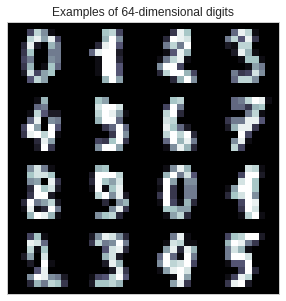

In [4]:
n=4; img=numpy.zeros((10*n,10*n))
for i in range(n): 
    for j in range(n): 
      img[(10*i+1):(10*i+9),(10*j+1):(10*j+9)]=X3[i*n+j].reshape((8,8))
pylab.figure(figsize=(5,5)); pylab.imshow(img,cmap=pylab.cm.bone)
pylab.title('Examples of 64-dimensional digits')
pylab.xticks([]); pylab.yticks([]); pylab.show()

artificial datasets

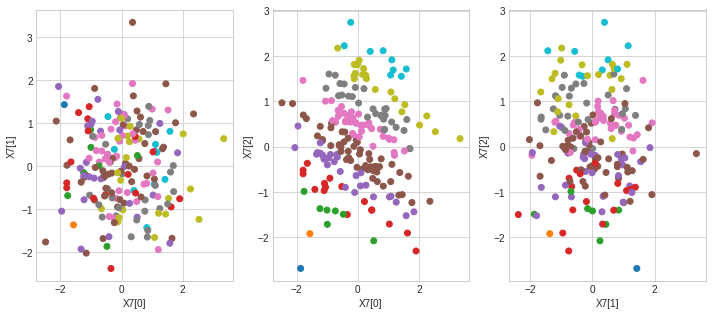

In [5]:
# 25000x3 matrix, 3 features (2 responsible for targets), 
# 1 target, 0.97 - the bias factor
[X7,y7]=datasets.make_regression(25000,3,2,1,0.97)
f,ax=pylab.subplots(ncols=3,figsize=(12,5)); k=[[0,1],[0,2],[1,2]]
[ax[i].scatter(X7[:200,k[i][0]], X7[:200,k[i][1]],c=y7[:200],
               cmap=pylab.cm.tab10) for i in range(3)]
[ax[i].set_xlabel('X7[%d]'%k[i][0]) for i in range(3)]
[ax[i].set_ylabel('X7[%d]'%k[i][1]) for i in range(3)]
pylab.show()
# 5000x10 matrix, 10 features (8 - responsible for targets), 
# 2 targets, 0.7 - the bias factor, 10.0 - the noise
[X8,y8]=datasets.make_regression(5000,10,8,2,0.7,noise=10.0)

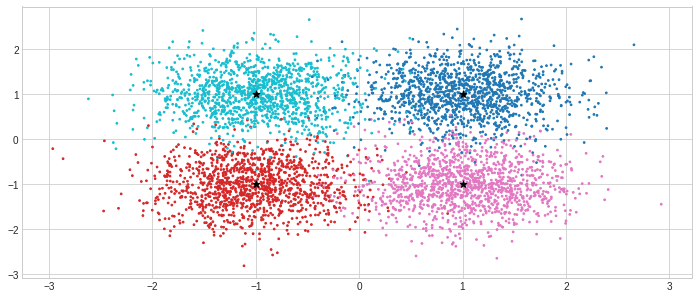

In [6]:
# Gaussian blobs for clustering, 5000 data points, 4 clusters
[X9,y9]=datasets.make_blobs(n_samples=5000,
                            centers=[[1,1],[-1,-1],[1,-1],[-1,1]],
                            cluster_std=0.5)
pylab.figure(figsize=(12,5))
pylab.scatter(X9[:,0],X9[:,1],c=y9,cmap=pylab.cm.tab10,s=3)
pylab.scatter([1,-1,1,-1],[1,-1,-1,1],c='black',marker='*',s=50)
pylab.show()

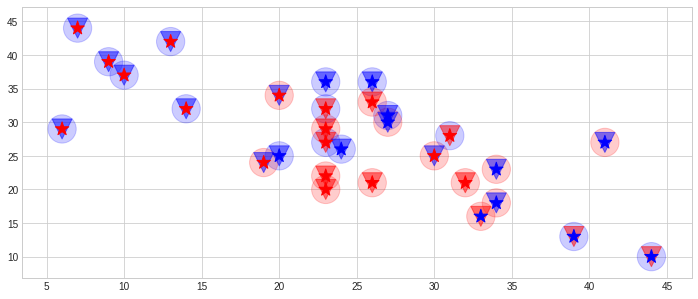

In [7]:
# 25000 data points, 2 features, 1 target with 3 labels
[X10,y10]=datasets.make_multilabel_classification(n_classes=3,
                                                  n_samples=25000,n_features=2)
f,ax=pylab.subplots(1,figsize=(12,5)); m=['o','v','*']
a=[0.2,0.5,1]; s=[800,400,200]
[ax.scatter(X10[:30,0],X10[:30,1],c=y10[:30,i],marker=m[i],
            alpha=a[i],cmap=pylab.cm.bwr,s=s[i]) for i in range(3)]
pylab.show()

external datasets

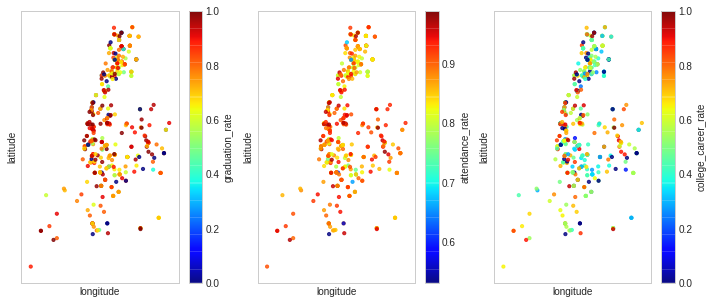

In [8]:
path='https://data.cityofnewyork.us/resource/'
f='h7rb-945c.json'
input_file=urllib.request.urlopen(path+f)
output_file=open(f,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
se=pandas.read_json(f)
feature_list=['dbn','ell_programs','language_classes',
              'finalgrades','total_students',
              'graduation_rate','attendance_rate',
              'college_career_rate','pct_stu_safe',
              'pct_stu_enough_variety','latitude','longitude',
              'council_district','city']
se=se[feature_list].dropna(); f,ax=pylab.subplots(ncols=3,figsize=(12,5))
for i in range(3):
    se[feature_list[i+5]]=se[feature_list[i+5]].astype('U')\
    .str.replace("N/A","0").astype('float')
    se.plot(kind="scatter",x="longitude",y="latitude",s=10,c=feature_list[i+5],
            cmap=pylab.cm.jet,ax=ax[i],alpha=0.8)
    ax[i].set_xticks([]); ax[i].set_yticks([]);
pylab.show()

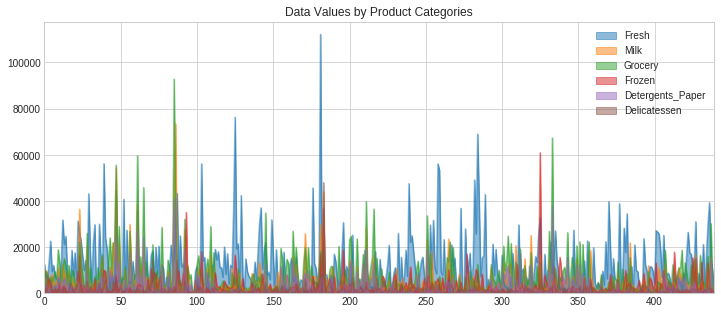

In [9]:
user="https://raw.githubusercontent.com/OlgaBelitskaya/"
path="machine_learning_engineer_nd009/master/Machine_Learning_Engineer_ND_P3/"
f="customers.csv"
input_file=urllib.request.urlopen(user+path+f)
output_file=open(f,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
data=pandas.read_csv(f)
data.drop(['Region','Channel'],axis=1,inplace=True)
data.plot.area(stacked=False,figsize=(12,5)); 
pylab.title('Data Values by Product Categories'); pylab.show()

б


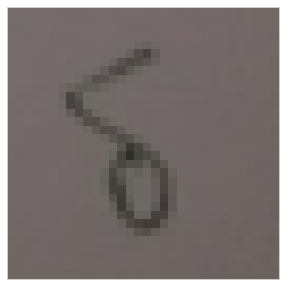

In [10]:
path='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(path+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r'); keys=list(f.keys())
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
backgrounds=numpy.array(f[keys[0]])
letter_images=numpy.array(f[keys[1]])/255
targets=numpy.array(f[keys[2]])
print(letters[targets[2000]-1]); pylab.figure(figsize=(5,5))
pylab.xticks([]); pylab.yticks([]); 
pylab.imshow(letter_images[2000]); pylab.show()

3 2


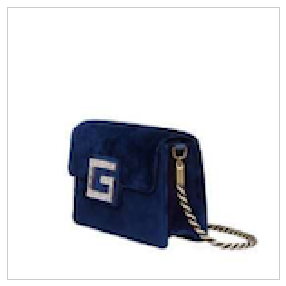

In [11]:
path='https://olgabelitskaya.github.io/'
zf='StyleColorImages.h5.zip'
input_file=urllib.request.urlopen(path+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r'); keys=list(f.keys()); 
brands=numpy.array(f[keys[0]])
style_images=numpy.array(f[keys[1]])/255
products=numpy.array(f[keys[2]])
print(brands[1000],products[1000]); pylab.figure(figsize=(5,5))
pylab.xticks([]); pylab.yticks([]); 
pylab.imshow(style_images[1000]); pylab.show()

# Extraction and Preprocessing

extraction

[[ 0  0  0  1  0  0 33]
 [ 0  0  1  0  0  0 16]
 [ 0  0  0  0  1  0 28]
 [ 0  0  0  0  0  1 38]
 [ 0  1  0  0  0  0 17]
 [ 1  0  0  0  0  0 27]]
['city=Ankara', 'city=Barcelona', 'city=Frankfurt', 'city=Hanoi', 'city=Houston', 'city=Riyadh', 'temperature']


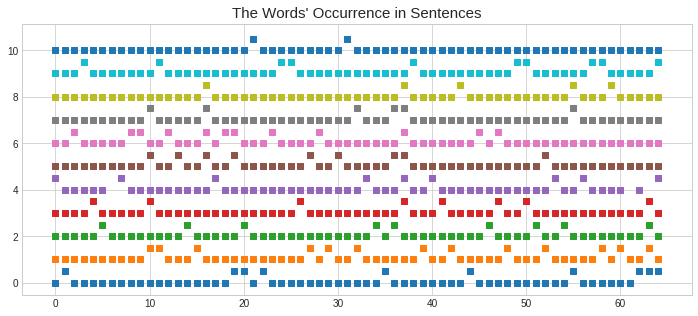

['have', 'you', 'already', 'set', 'your', 'goals', 'for', 'the', 'new', 'year']


In [12]:
temperature=[{'city':'Hanoi','temperature':33.},
             {'city':'Frankfurt','temperature':16.},
             {'city':'Houston','temperature':28.},
             {'city':'Riyadh','temperature':38.},
             {'city':'Barcelona','temperature':17.},
             {'city':'Ankara','temperature':27.}]
corpus=['Have you already set your goals for the New Year?',
        'Do you want to lose ten kilos, run a marathon or speak fluent English?', 
        'Some experts believe that you need systems, not goals.',
        'A system is something you do on a regular basis.',
        'This means focusing on what you can control '+\
        '(your actions) rather than what you can’t.',
        'For example, do not focus on losing ten kilos.',
        'Focus on shopping for healthy food and '+\
        'cooking something light every day.',
        'Do not focus on the marathon.',
        'Focus on the training schedule.',
        'Invent a system to improve your English, one step at a time.',
        'Good luck!']
dv=DictVectorizer() 
temperature_features=dv.fit_transform(temperature).toarray().astype('int16')
print(temperature_features); print(dv.get_feature_names())
cv=CountVectorizer(min_df=1)
corpus_features=cv.fit_transform(corpus)
corpus_array=corpus_features.toarray().astype('int16')
c_analyzer=cv.build_analyzer()
pylab.figure(figsize=(12,5))
for i in range(len(corpus_array)): 
  pylab.scatter(range(len(corpus_array[i])),
                (corpus_array[i]*0.5+i),marker='s')
pylab.title("The Words' Occurrence in Sentences",fontsize=15)
pylab.show()
print(c_analyzer(corpus[0]))

In [0]:
vectorizer=TfidfVectorizer(sublinear_tf=True,max_df=.5,stop_words='english')
x_train6=vectorizer.fit_transform(train.data)
x_test6=vectorizer.transform(test.data)
y_train6,y_test6=train.target,test.target
del train,test

scaling

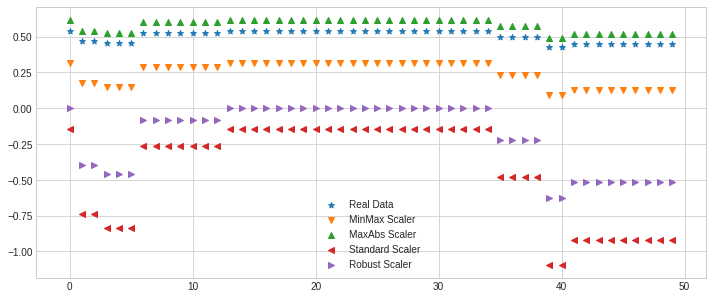

In [14]:
SCX1=[X1,preprocessing.MinMaxScaler().fit_transform(X1),
      preprocessing.MaxAbsScaler().fit_transform(X1),
      preprocessing.StandardScaler().fit_transform(X1),
      preprocessing.RobustScaler().fit_transform(X1)]
n=50; pylab.figure(figsize=(12,5))
m=['*','v','^','<','>']
labels=['Real Data','MinMax Scaler','MaxAbs Scaler',
        'Standard Scaler','Robust Scaler']
for i in range(5): 
  pylab.scatter(range(n),SCX1[i][:n,4],
                marker=m[i],label=labels[i])
pylab.legend(loc=8); pylab.show()

one-hot encoding

In [15]:
cat_brands,cat_products,cat_backgrounds,cat_targets=\
ohe(brands),ohe(products),ohe(backgrounds),ohe(targets)
print([targets[99:102],'=>',cat_targets[99:102]])

[array([2, 3, 3]), '=>', array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int16)]


imputation of missing values

In [16]:
x1_train=[[0,17],[numpy.nan,4],[1,7],[3,numpy.nan],[5,12],[10,25]]
x1_test=[[numpy.nan,5],[3,15],[8,numpy.nan],[4,11]]
# mean & median imputers, custom transformer (log)
mean_imp=impute.SimpleImputer(strategy='mean')
median_imp=impute.SimpleImputer(strategy='median')
log_trans=preprocessing.FunctionTransformer(numpy.log1p,validate=False)
mean_imp.fit(x1_train); median_imp.fit(x1_train)
x1_train_log=log_trans.transform(median_imp.transform(x1_train))
x1_test_log=log_trans.transform(median_imp.transform(x1_test))
for el in [x1_test,mean_imp.transform(x1_test),
           median_imp.transform(x1_test),x1_test_log]:
    print(el)

[[nan, 5], [3, 15], [8, nan], [4, 11]]
[[ 3.8  5. ]
 [ 3.  15. ]
 [ 8.  13. ]
 [ 4.  11. ]]
[[ 3.  5.]
 [ 3. 15.]
 [ 8. 12.]
 [ 4. 11.]]
[[1.3863 1.7918]
 [1.3863 2.7726]
 [2.1972 2.5649]
 [1.6094 2.4849]]


features' importance

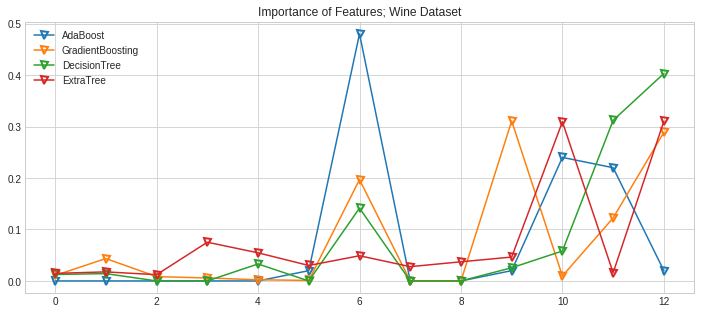

In [17]:
classifiers=[AdaBoostClassifier,GradientBoostingClassifier,
             DecisionTreeClassifier,ExtraTreeClassifier]
labels=['AdaBoost','GradientBoosting','DecisionTree','ExtraTree']
pylab.figure(figsize=(12,5))
df_importance=pandas.DataFrame(columns=range(13))
for i in range(4):
    df_importance.loc[i]=\
    classifiers[i]().fit(X4,y4).feature_importances_
    pylab.plot(df_importance.loc[i],'-v',label=labels[i],
               markersize=7,markerfacecolor="None",markeredgewidth=2)
pylab.legend(loc=2,fontsize=10)
pylab.title("Importance of Features; Wine Dataset"); pylab.show()

dimensionality reduction

Univariate Selection, Recursive Feature Elimination, Principal Component Analysis, etc.

In [18]:
# Univariate Selection; Wine Dataset
select_kbest=SelectKBest(score_func=chi2,k=4)
fit_select_kbest=select_kbest.fit(X4,y4)
features_select_kbest=fit_select_kbest.transform(X4)
print(("Kbest scores: \n%s")%fit_select_kbest.scores_)
print(("Selected features: \n%s")%features_select_kbest[0:5,:])
# Recursive Feature Elimination; Wine Dataset
rfe=RFE(linear_model.LogisticRegression(solver='liblinear',multi_class='ovr'),3)
fit_rfe=rfe.fit(X4,y4)
print(("RFE Selected Features: \n%s")%fit_rfe.support_)
print(("Feature Ranking: \n%s")%fit_rfe.ranking_)
# Principal Component Analysis; Boston Dataset
pca3=PCA(n_components=3); fit_pca=pca3.fit(X1)
print(("Explained Variance: \n%s\n")%fit_pca.explained_variance_ratio_)
print(fit_pca.components_[0],'\n'); print(fit_pca.components_[1],'\n')
print(fit_pca.components_[2])

Kbest scores: 
[5.4455e+00 2.8069e+01 7.4338e-01 2.9384e+01 4.5026e+01 1.5623e+01
 6.3334e+01 1.8155e+00 9.3683e+00 1.0902e+02 5.1825e+00 2.3390e+01
 1.6540e+04]
Selected features: 
[[ 127.      3.06    5.64 1065.  ]
 [ 100.      2.76    4.38 1050.  ]
 [ 101.      3.24    5.68 1185.  ]
 [ 113.      3.49    7.8  1480.  ]
 [ 118.      2.69    4.32  735.  ]]
RFE Selected Features: 
[False False False False False False  True False False  True  True False
 False]
Feature Ranking: 
[ 9  5  2  4 10  8  1  7  6  1  1  3 11]
Explained Variance: 
[0.8058 0.1631 0.0213]

[ 2.9297e-02 -4.3590e-02  2.8331e-02 -5.5585e-05  4.4972e-04 -1.1682e-03
  8.3634e-02 -6.5616e-03  4.5005e-02  9.4974e-01  5.6001e-03 -2.9122e-01
  2.2943e-02] 

[ 6.6685e-03  1.1756e-03 -4.9498e-03 -1.0268e-04  1.8207e-06  3.6575e-04
 -5.7225e-03  3.5369e-04 -8.6187e-03 -2.9241e-01 -2.5290e-03 -9.5618e-01
  5.7672e-03] 

[-0.0115  0.6329 -0.0883 -0.001  -0.0018  0.0047 -0.7559  0.0451  0.0028
  0.0939 -0.0112 -0.0236 -0.0928]


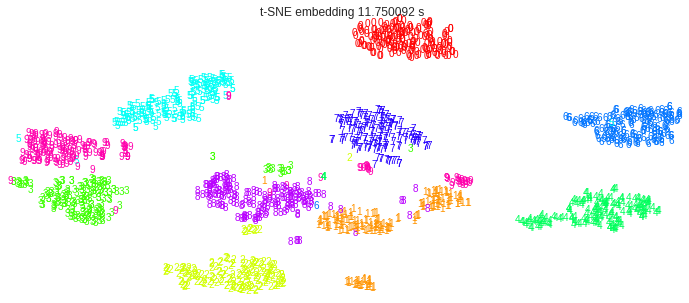

In [19]:
t0=time.time()
X_emb=manifold.TSNE(n_components=2,learning_rate=700.0).fit_transform(X3)
x_min,x_max=numpy.min(X_emb,0),numpy.max(X_emb,0)
X_emb=(X_emb-x_min)/(x_max-x_min)
f,ax=pylab.subplots(1,figsize=(12,5))
pylab.axis("off")
for i in range(X_emb.shape[0]):
    pylab.text(X_emb[i,0],X_emb[i,1],str(y3[i]),
               color=pylab.cm.hsv(y3[i]/10.))
pylab.title("t-SNE embedding %f s"%(time.time()-t0)); pylab.show()

shuffling and splitting

In [20]:
Xy=[sas(X1,y1),sas(X2,y2),sas(X3,y3),sas(X4,y4),sas(X5,y5)]
[[X_train1,X_test1,y_train1,y_test1],[X_train2,X_test2,y_train2,y_test2],
 [X_train3,X_test3,y_train3,y_test3],[X_train4,X_test4,y_train4,y_test4],
 [X_train5,X_test5,y_train5,y_test5]]=Xy
[print([Xy[i][j].shape for j in range(4)]) for i in range(5)]
print('boston, housing, digits, wine, faces')
del X1,y1,X2,y2,X3,y3,X4,y4,X5,y5

[(404, 13), (102, 13), (404,), (102,)]
[(16512, 8), (4128, 8), (16512,), (4128,)]
[(1437, 64), (360, 64), (1437,), (360,)]
[(142, 13), (36, 13), (142,), (36,)]
[(320, 4096), (80, 4096), (320,), (80,)]
boston, housing, digits, wine, faces


In [21]:
Xy2=[sas(X7,y7),sas(X8,y8),sas(X9,y9),sas(X10,y10)]
[[X_train7,X_test7,y_train7,y_test7],
 [X_train8,X_test8,y_train8,y_test8],
 [X_train9,X_test9,y_train9,y_test9],
 [X_train10,X_test10,y_train10,y_test10]]=Xy2
[print([Xy2[i][j].shape for j in range(4)]) for i in range(4)]
print('toy datasets: regression, regression 2, blobs, classification')
del X7,y7,X8,y8,X9,y9,X10,y10

[(20000, 3), (5000, 3), (20000,), (5000,)]
[(4000, 10), (1000, 10), (4000, 2), (1000, 2)]
[(4000, 2), (1000, 2), (4000,), (1000,)]
[(20000, 2), (5000, 2), (20000, 3), (5000, 3)]
toy datasets: regression, regression 2, blobs, classification


In [22]:
Xy3=[sas(letter_images,targets),sas(letter_images,backgrounds),
     sas(style_images,brands),sas(style_images,products)]
[[X_train11,X_test11,y_train11,y_test11],
 [X_train12,X_test12,y_train12,y_test12],
 [X_train13,X_test13,y_train13,y_test13],
 [X_train14,X_test14,y_train14,y_test14]]=Xy3
[print([Xy3[i][j].shape for j in range(4)]) for i in range(4)]
print('letters and labels, letters and backgrounds, '+\
      'style images and brands, style images and products')
del letter_images,targets,backgrounds,style_images,brands,products

[(11352, 32, 32, 3), (2838, 32, 32, 3), (11352,), (2838,)]
[(11352, 32, 32, 3), (2838, 32, 32, 3), (11352,), (2838,)]
[(1747, 150, 150, 3), (437, 150, 150, 3), (1747,), (437,)]
[(1747, 150, 150, 3), (437, 150, 150, 3), (1747,), (437,)]
letters and labels, letters and backgrounds, style images and brands, style images and products


# Supervised Learning. Classification

In [0]:
def classifier_fit_score(classifier,classifier_name,
                         clf_dataset,x_train,x_test,y_train,y_test):
    classifier.fit(x_train,y_train)
    clf_datasets.append(clf_dataset)
    classifier_list.append(str(classifier))
    classifier_names.append(classifier_name)    
    y_clf_train=classifier.predict(x_train)
    y_clf_test=classifier.predict(x_test)        
    acc_clf_train=round(accuracy_score(y_train,y_clf_train),4)
    acc_clf_test=round(accuracy_score(y_test,y_clf_test),4)
    acc_train.append(acc_clf_train); acc_test.append(acc_clf_test)   
    loss_clf_train=round(hamming_loss(y_train,y_clf_train),4)
    loss_clf_test=round(hamming_loss(y_test,y_clf_test),4)
    loss_train.append(loss_clf_train); loss_test.append(loss_clf_test)    
    return [y_clf_train,y_clf_test,acc_clf_train,
            acc_clf_test,loss_clf_train,loss_clf_test]
def get_classifier_results():
    return pandas.DataFrame({'classifier':classifier_list,
                             'classifier_name':classifier_names,
                             'clf_dataset':clf_datasets,
                             'acc_train':acc_train,'acc_test':acc_test,
                             'loss_train':loss_train,'loss_test':loss_test})

In [0]:
classifier_list,classifier_names,clf_datasets=[],[],[]
acc_train,acc_test,loss_train,loss_test=[],[],[],[]
df_list=['classifier_name','acc_train','acc_test','loss_train','loss_test']
clf=[linear_model.LogisticRegression(solver='liblinear',multi_class='ovr'),
     linear_model.LogisticRegressionCV(solver='liblinear',multi_class='ovr'),
     linear_model.SGDClassifier(max_iter=1000,tol=0.00001),
     linear_model.RidgeClassifier(),linear_model.RidgeClassifierCV(),
     LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),
     svm.LinearSVC(),svm.SVC(gamma='scale',C=10.0,kernel='poly'),
     svm.NuSVC(gamma='scale',kernel='poly'),
     KNeighborsClassifier(),RadiusNeighborsClassifier(radius=30),
     NearestCentroid(),
     DecisionTreeClassifier(),ExtraTreeClassifier(),GaussianNB(),
     BernoulliNB(),MultinomialNB(),
     BaggingClassifier(),RandomForestClassifier(n_estimators=64),
     AdaBoostClassifier(),GradientBoostingClassifier(),
     linear_model.Perceptron(max_iter=1000,tol=0.00001),
     linear_model.PassiveAggressiveClassifier(max_iter=1000,tol=0.00001),
     GaussianProcessClassifier(),LabelPropagation(),LabelSpreading()]

In [0]:
list3clf=['LogisticRegression','LogisticRegressionCV','SGDClassifier',
          'RidgeClassifier', 'RidgeClassifierCV',
          'LinearDiscriminantAnalysis','QuadraticDiscriminantAnalysis',
          'LinearSVC', 'SVC','NuSVC',
          'KNeighborsClassifier','RadiusNeighborsClassifier','NearestCentroid', 
          'DecisionTreeClassifier','ExtraTreeClassifier',
          'GaussianNB','BernoulliNB','MultinomialNB',
          'BaggingClassifier','RandomForestClassifier',
          'AdaBoostClassifier','GradientBoostingClassifier',
          'Perceptron','PassiveAggressiveClassifier']
y3clf=[]
for i in range(len(list3clf)):
    y3clf.append(classifier_fit_score(clf[i],list3clf[i],'Digits',
                                      X_train3,X_test3,y_train3,y_test3)[:2])
[[y_train31,y_test31],[y_train32,y_test32],
 [y_train33,y_test33],[y_train34,y_test34],[y_train35,y_test35],
[y_train36,y_test36],[y_train37,y_test37],[y_train38,y_test38],
 [y_train39,y_test39],[y_train310,y_test310],
[y_train311,y_test311],[y_train312,y_test312],
 [y_train313,y_test313],[y_train314,y_test314],[y_train315,y_test315],
[y_train316,y_test316],[y_train317,y_test317],[y_train318,y_test318],
 [y_train319,y_test319],[y_train320,y_test320],
[y_train321,y_test321],[y_train322,y_test322],[y_train323,y_test323],
 [y_train324,y_test324]]=y3clf
y_train925,y_test925=\
classifier_fit_score(clf[24],'GaussianProcessClassifier','Toy Blobs',
                     X_train9,X_test9,y_train9,y_test9)[:2]
y_train926,y_test926=\
classifier_fit_score(clf[25],'LabelPropagation','Toy Blobs',
                     X_train9,X_test9,y_train9,y_test9)[:2]
y_train927,y_test927=\
classifier_fit_score(clf[26],'LabelSpreading','Toy Blobs',
                     X_train9,X_test9,y_train9,y_test9)[:2]

In [0]:
y_train1111,y_test1111=\
classifier_fit_score(clf[10],'KNeighborsClassifier','Handwritten Letters',
                     X_train11.reshape(-1,32*32*3),X_test11.reshape(-1,32*32*3),
                     y_train11,y_test11)[:2]
#y_train1119,y_test1119=\
#classifier_fit_score(clf[18],'BaggingClassifier','Handwritten Letters',
#                     X_train11.reshape(-1,32*32*3),X_test11.reshape(-1,32*32*3),
#                     y_train11,y_test11)[:2]
#y_train1120,y_test1120=\
#classifier_fit_score(clf[19],'RandomForestClassifier','Handwritten Letters',
#                     X_train11.reshape(-1,32*32*3),X_test11.reshape(-1,32*32*3),
#                     y_train11,y_test11)[:2]
#y_train1122,y_test1122=\
#classifier_fit_score(clf[21],'GradientBoostingClassifier','Handwritten Letters',
#                     X_train11.reshape(-1,32*32*3),X_test11.reshape(-1,32*32*3),
#                     y_train11,y_test11)[:2]

In [27]:
df_classifier_results=get_classifier_results()
df_classifier_results.to_csv('classifier_results.csv')
df_classifier_results[df_list].sort_values('acc_test',ascending=False).\
style.set_properties(**style_dict)

,classifier_name,acc_train,acc_test,loss_train,loss_test
11,RadiusNeighborsClassifier,0.9763,0.9944,0.0237,0.0056
10,KNeighborsClassifier,0.9882,0.9944,0.0118,0.0056
8,SVC,1,0.9861,0,0.0139
19,RandomForestClassifier,1,0.9833,0,0.0167
1,LogisticRegressionCV,0.9847,0.9722,0.0153,0.0278
0,LogisticRegression,0.9965,0.9694,0.0035,0.0306
23,PassiveAggressiveClassifier,0.9749,0.9694,0.0251,0.0306
7,LinearSVC,0.984,0.9639,0.016,0.0361
9,NuSVC,0.9631,0.9639,0.0369,0.0361
5,LinearDiscriminantAnalysis,0.9659,0.9611,0.0341,0.0389


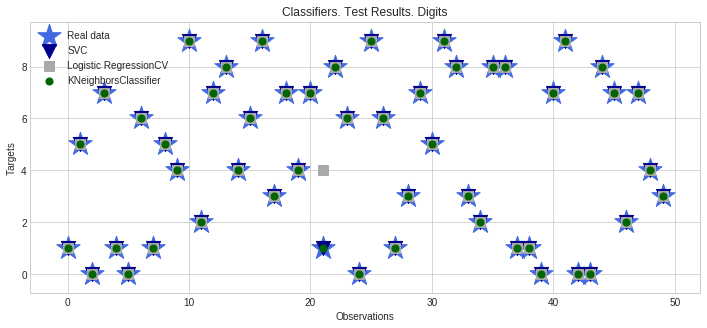

In [28]:
pylab.figure(figsize=(12,5)); n=50; x=range(n)
pylab.scatter(x,y_test3[:n],marker='*',s=600,
              color='royalblue',label='Real data')
pylab.scatter(x,y_test39[:n],marker='v',s=200,
              color='darkblue',label='SVC')
pylab.scatter(x,y_test32[:n],marker='s',s=100,
              color='darkgrey',label='Logistic RegressionCV')
pylab.scatter(x,y_test311[:n],marker='o',s=50,
              color='darkgreen',label='KNeighborsClassifier')
pylab.xlabel('Observations'); pylab.ylabel('Targets')
pylab.title('Classifiers. Test Results. Digits')
pylab.legend(loc=2,fontsize=10); pylab.show()

# Supervised Learning. Regression

In [0]:
def regressor_fit_score(regressor,regressor_name,dataset,
                        x_train,x_test,y_train,y_test):
    regressor_list.append(str(regressor))
    regressor_names.append(regressor_name)
    reg_datasets.append(dataset)    
    regressor.fit(x_train,y_train)
    y_reg_train=regressor.predict(x_train)
    y_reg_test=regressor.predict(x_test)    
    r2_reg_train=round(r2_score(y_train,y_reg_train),4)
    r2_train.append(r2_reg_train)
    r2_reg_test=round(r2_score(y_test,y_reg_test),4)
    r2_test.append(r2_reg_test)    
    ev_reg_train=round(explained_variance_score(y_train,y_reg_train),4)
    ev_train.append(ev_reg_train)
    ev_reg_test=round(explained_variance_score(y_test, y_reg_test),4)
    ev_test.append(ev_reg_test)    
    mse_reg_train=round(mean_squared_error(y_train,y_reg_train),4)
    mse_train.append(mse_reg_train)
    mse_reg_test=round(mean_squared_error(y_test,y_reg_test),4)
    mse_test.append(mse_reg_test)
    mae_reg_train=round(mean_absolute_error(y_train,y_reg_train),4)
    mae_train.append(mae_reg_train)
    mae_reg_test=round(mean_absolute_error(y_test,y_reg_test),4)
    mae_test.append(mae_reg_test)
    mdae_reg_train=round(median_absolute_error(y_train,y_reg_train),4)
    mdae_train.append(mdae_reg_train)
    mdae_reg_test=round(median_absolute_error(y_test,y_reg_test),4)
    mdae_test.append(mdae_reg_test)    
    return [y_reg_train,y_reg_test,r2_reg_train,r2_reg_test,
            ev_reg_train,ev_reg_test,
            mse_reg_train,mse_reg_test,mae_reg_train,mae_reg_test,
            mdae_reg_train,mdae_reg_test]
def get_regressor_results():
    return pandas.DataFrame({'regressor':regressor_list,
                             'regressor_name':regressor_names,
                             'dataset':reg_datasets,
                             'r2_train':r2_train,'r2_test':r2_test,
                             'ev_train':ev_train,'ev_test':ev_test,
                             'mse_train':mse_train,'mse_test':mse_test,
                             'mae_train':mae_train,'mae_test':mae_test,
                             'mdae_train':mdae_train,'mdae_test':mdae_test})

In [0]:
regressor_list,regressor_names,reg_datasets=[],[],[]
r2_train,r2_test,ev_train, ev_test,mse_train,mse_test,mae_train,\
mae_test,mdae_train,mdae_test=[],[],[],[],[],[],[],[],[],[]
df_list2=['regressor_name','r2_train','r2_test','ev_train','ev_test',
          'mse_train','mse_test','mae_train','mae_test',
          'mdae_train','mdae_test']
reg=[linear_model.LinearRegression(),
     linear_model.Ridge(),linear_model.RidgeCV(),
     linear_model.Lasso(),linear_model.LassoLarsCV(),
     linear_model.RANSACRegressor(),
     linear_model.BayesianRidge(),linear_model.ARDRegression(),
     linear_model.HuberRegressor(),linear_model.TheilSenRegressor(),
     PLSRegression(),DecisionTreeRegressor(),ExtraTreeRegressor(),
     BaggingRegressor(),AdaBoostRegressor(),
     GradientBoostingRegressor(),RandomForestRegressor(),
     linear_model.PassiveAggressiveRegressor(max_iter=1000,tol=0.001),
     linear_model.ElasticNet(),
     linear_model.SGDRegressor(max_iter=1000,tol=0.001),
     svm.SVR(),KNeighborsRegressor(),
     RadiusNeighborsRegressor(radius=1.5),GaussianProcessRegressor()]

In [0]:
list1reg=['LinearRegression','Ridge','RidgeCV',
          'Lasso','LassoLarsCV','RANSACRegressor',
          'BayesianRidge','ARDRegression','HuberRegressor',
          'TheilSenRegressor','PLSRegression','DecisionTreeRegressor',
          'ExtraTreeRegressor','BaggingRegressor','AdaBoostRegressor',
          'GradientBoostingRegressor','RandomForestRegressor']
y1reg=[]; y7reg=[]
for i in range(len(list1reg)):
    y1reg.append(regressor_fit_score(reg[i],list1reg[i],'Boston',
                                     X_train1,X_test1,y_train1,y_test1)[:2])
[[y_train101,y_test101],[y_train102,y_test102],[y_train103,y_test103],
 [y_train104,y_test104],[y_train105,y_test105],[y_train106,y_test106],
 [y_train107,y_test107],[y_train108,y_test108],[y_train109,y_test109],
 [y_train110,y_test110],[y_train111,y_test111],[y_train112,y_test112],
 [y_train113,y_test113],[y_train114,y_test114],[y_train115,y_test115],
 [y_train116,y_test116],[y_train117,y_test117]]=y1reg
list7reg=['PassiveAggressiveRegressor','ElasticNet','SGDRegressor','SVR',
          'KNeighborsRegressor','RadiusNeighborsRegressor',
          'GaussianProcessRegressor']
for i in range(len(list7reg)):
    y7reg.append(regressor_fit_score(reg[i],list7reg[i],'Toy Regression',
                                     X_train7,X_test7,y_train7,y_test7)[:2])
[[y_train718,y_test718],[y_train719,y_test719],[y_train720,y_test720],
 [y_train721,y_test721],[y_train722,y_test722],
 [y_train723,y_test723],[y_train724,y_test724]]=y7reg

In [32]:
df_regressor_results=get_regressor_results()
df_regressor_results.to_csv('regressor_results.csv')
df_regressor_results[df_list2].sort_values('r2_test',ascending=False)\
.style.set_properties(**style_dict)

,regressor_name,r2_train,r2_test,ev_train,ev_test,mse_train,mse_test,mae_train,mae_test,mdae_train,mdae_test
23,GaussianProcessRegressor,1,1,1,1,0,0,0,0,0,0
22,RadiusNeighborsRegressor,1,1,1,1,0,0,0,0,0,0
21,KNeighborsRegressor,1,1,1,1,0,0,0,0,0,0
19,SGDRegressor,1,1,1,1,0,0,0.0001,0.0001,0.0001,0.0001
18,ElasticNet,1,1,1,1,0,0,0.001,0.001,0.0008,0.0009
17,PassiveAggressiveRegressor,1,1,1,1,0,0,0,0,0,0
20,SVR,0.9966,0.9966,0.9966,0.9966,2.0478,2.1103,1.143,1.1636,0.9625,0.9816
15,GradientBoostingRegressor,0.9779,0.9227,0.9779,0.923,1.7841,7.6384,1.0462,2.191,0.8733,1.7703
13,BaggingRegressor,0.9768,0.9129,0.9768,0.9132,1.8743,8.6114,0.8988,2.2481,0.58,1.645
16,RandomForestRegressor,0.9813,0.9061,0.9813,0.9061,1.5102,9.283,0.8183,2.3485,0.5595,1.768


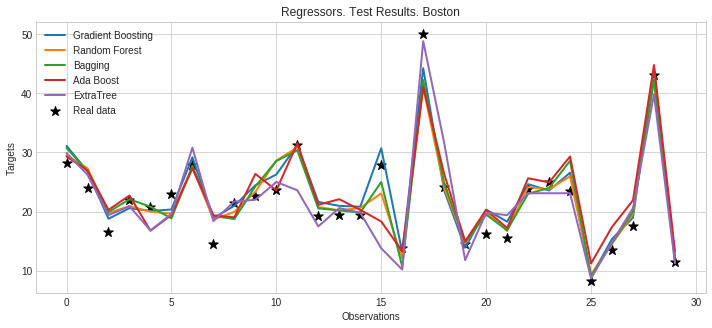

In [33]:
pylab.figure(figsize=(12,5)); n=30; x=range(n)
pylab.scatter(x,y_test1[:n],marker='*',s=100,color='black',label='Real data')
pylab.plot(x,y_test116[:n],lw=2,label='Gradient Boosting')
pylab.plot(x,y_test117[:n],lw=2,label='Random Forest')
pylab.plot(x,y_test114[:n],lw=2,label='Bagging')
pylab.plot(x,y_test115[:n],lw=2,label='Ada Boost')
pylab.plot(x,y_test113[:n],lw=2,label='ExtraTree')
pylab.xlabel('Observations'); pylab.ylabel('Targets')
pylab.title('Regressors. Test Results. Boston')
pylab.legend(loc=2,fontsize=10); pylab.show()

combining regression with kernels

0.9960579191945871


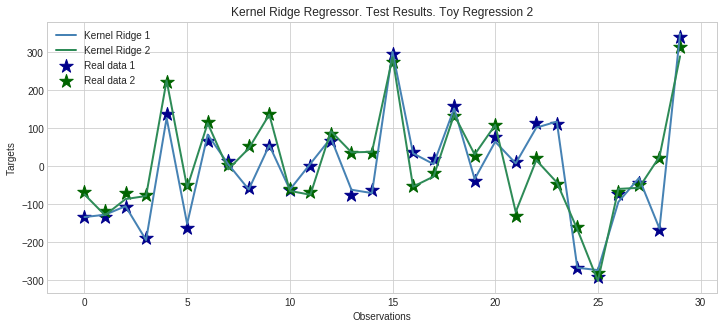

In [34]:
# Kernel Ridge; Toy regression 2
reg25=KernelRidge(); reg25.fit(X_train8,y_train8)
y_train825=reg25.predict(X_train8) 
y_test825=reg25.predict(X_test8)
print(reg25.score(X_test8,y_test8))
pylab.figure(figsize=(12,5)); n=30; x=range(n)
pylab.scatter(x,y_test8[:n,0],marker='*',s=200,
              color='darkblue',label='Real data 1')
pylab.scatter(x,y_test8[:n,1],marker='*',s=200,
              color='darkgreen',label='Real data 2')
pylab.plot(x,y_test825[:n,0],lw=2,
           color='steelblue',label='Kernel Ridge 1')
pylab.plot(x,y_test825[:n,1],lw=2,
           color='seagreen',label='Kernel Ridge 2')
pylab.xlabel('Observations'); pylab.ylabel('Targets') 
pylab.title('Kernel Ridge Regressor. Test Results. Toy Regression 2')
pylab.legend(loc=2,fontsize=10); pylab.show()

# Unsupervised Learning

In [0]:
usl=[mixture.GaussianMixture(n_components=4,n_init=4),
     mixture.BayesianGaussianMixture(n_components=4,n_init=4),
     manifold.Isomap(),manifold.LocallyLinearEmbedding(),
     manifold.SpectralEmbedding(),manifold.MDS(),manifold.TSNE()]
# Gaussian Mixture; Toy blobs
usl[0].fit(X_train9,y_train9); y_test91=usl[0].predict(X_test9)
usl[1].fit(X_train9,y_train9); y_test92=usl[1].predict(X_test9)

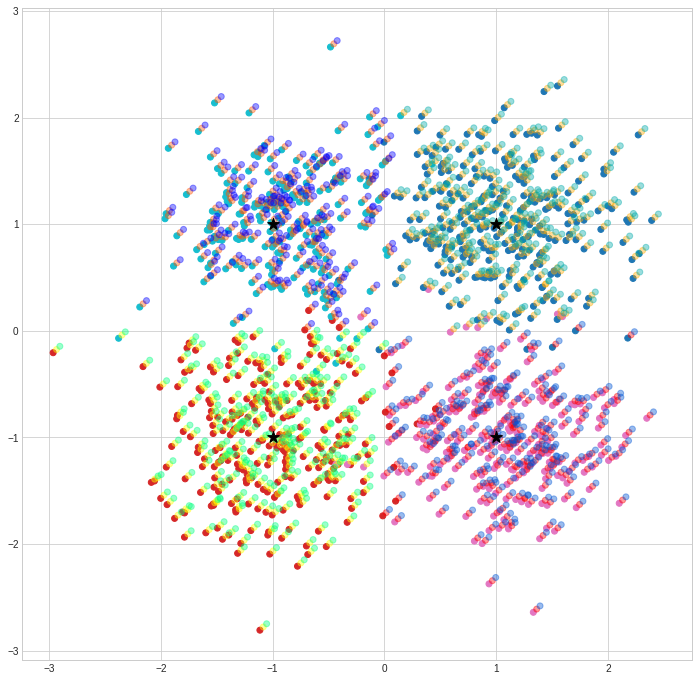

In [36]:
pylab.figure(figsize=(12,12))
pylab.scatter(X_test9[:,0],X_test9[:,1],c=y_test9,cmap=pylab.cm.tab10)
pylab.scatter(X_test9[:,0]+0.03,X_test9[:,1]+0.03,
              c=y_test91,alpha=0.4,cmap=pylab.cm.autumn)
pylab.scatter(X_test9[:,0]+0.06,X_test9[:,1]+0.06,
              c=y_test92,alpha=0.4,cmap=pylab.cm.winter)
pylab.scatter([1,-1,1,-1],[1,-1,-1,1],c='black',marker='*',s=150)
pylab.show()

# Neural Networks
supervised

In [37]:
# Multi-layer Perceptron; Classifier; Digits
nn_clf1=MLPClassifier(hidden_layer_sizes=(512,),max_iter=70,
                      solver='sgd',verbose=1,
                      random_state=1,learning_rate_init=.01)
nn_clf1.fit(X_train3,y_train3)
nn_clf1.score(X_train3,y_train3),nn_clf1.score(X_test3,y_test3)

Iteration 1, loss = 8.00530122
Iteration 2, loss = 0.40345160
Iteration 3, loss = 0.18567301
Iteration 4, loss = 0.11457804
Iteration 5, loss = 0.08503822
Iteration 6, loss = 0.07348423
Iteration 7, loss = 0.05662412
Iteration 8, loss = 0.05273783
Iteration 9, loss = 0.04391314
Iteration 10, loss = 0.03620788
Iteration 11, loss = 0.03801262
Iteration 12, loss = 0.02911084
Iteration 13, loss = 0.02615359
Iteration 14, loss = 0.02538807
Iteration 15, loss = 0.02224096
Iteration 16, loss = 0.02030931
Iteration 17, loss = 0.01865935
Iteration 18, loss = 0.01775010
Iteration 19, loss = 0.01648355
Iteration 20, loss = 0.01585530
Iteration 21, loss = 0.01461249
Iteration 22, loss = 0.01422504
Iteration 23, loss = 0.01337695
Iteration 24, loss = 0.01259988
Iteration 25, loss = 0.01190659
Iteration 26, loss = 0.01152053
Iteration 27, loss = 0.01214406
Iteration 28, loss = 0.01080019
Iteration 29, loss = 0.01008233
Iteration 30, loss = 0.00954526
Iteration 31, loss = 0.00908236
Iteration 32, los

(1.0, 0.9916666666666667)

In [38]:
# Multi-layer Perceptron; Classifier; Handwritten letters
nn_clf2=MLPClassifier(hidden_layer_sizes=(1024,),max_iter=300,solver='sgd',
                      verbose=1,random_state=1,learning_rate_init=.01)
n=12000; nn_clf2.fit(X_train11[:n].reshape(-1,32*32*3),y_train11[:n])
[nn_clf2.score(X_train11[:n].reshape(-1,32*32*3),y_train11[:n]),
nn_clf2.score(X_test11.reshape(-1,32*32*3),y_test11)]

Iteration 1, loss = 3.51959534
Iteration 2, loss = 3.42419504
Iteration 3, loss = 3.34592559
Iteration 4, loss = 3.25362677
Iteration 5, loss = 3.16130384
Iteration 6, loss = 3.08660355
Iteration 7, loss = 3.00822118
Iteration 8, loss = 2.95569201
Iteration 9, loss = 2.91435441
Iteration 10, loss = 2.83638562
Iteration 11, loss = 2.76769762
Iteration 12, loss = 2.74323550
Iteration 13, loss = 2.76864957
Iteration 14, loss = 2.71566994
Iteration 15, loss = 2.67979579
Iteration 16, loss = 2.61127060
Iteration 17, loss = 2.58840408
Iteration 18, loss = 2.55931470
Iteration 19, loss = 2.61005933
Iteration 20, loss = 2.53542363
Iteration 21, loss = 2.50550778
Iteration 22, loss = 2.52166959
Iteration 23, loss = 2.45465029
Iteration 24, loss = 2.40569864
Iteration 25, loss = 2.41481562
Iteration 26, loss = 2.40822731
Iteration 27, loss = 2.50315174
Iteration 28, loss = 2.36981792
Iteration 29, loss = 2.38099648
Iteration 30, loss = 2.33459549
Iteration 31, loss = 2.35133753
Iteration 32, los

[0.5429880197322058, 0.47181113460183227]

Iteration 1, loss = 1.48157142
Iteration 2, loss = 0.19998997
Iteration 3, loss = 0.11511956
0.7107010090281466


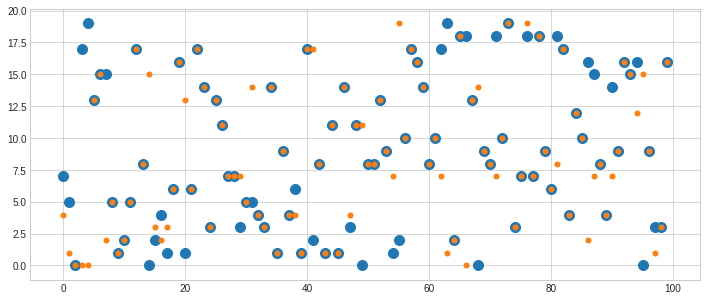

In [39]:
# Multi-layer Perceptron; Classifier; News
nn_clf3=MLPClassifier(hidden_layer_sizes=(128,),max_iter=3,solver='adam',
                      verbose=1,random_state=1,learning_rate_init=.01)
nn_clf3.fit(x_train6,y_train6); print(nn_clf3.score(x_test6,y_test6))
y_test6_predictions=nn_clf3.predict(x_test6)
pylab.figure(figsize=(12,5)); pylab.scatter(range(100),y_test6[:100],s=100)
pylab.scatter(range(100),y_test6_predictions[:100],s=25); pylab.show()

In [40]:
# Multi-layer Perceptron; Regressor; Boston
nn_reg1=MLPRegressor(hidden_layer_sizes=(104,),max_iter=1200,
                     solver='lbfgs',alpha=0.018)
nn_reg1.fit(X_train1,y_train1); y_test1_nn1=nn_reg1.predict(X_test1)
nn_reg1.score(X_train1,y_train1),nn_reg1.score(X_test1,y_test1)

(0.8960164085618842, 0.8781050362494848)

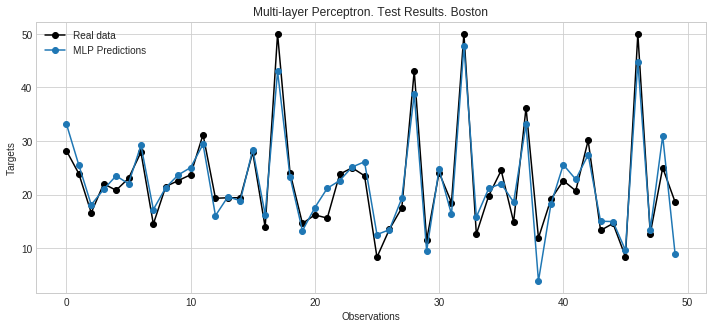

In [41]:
pylab.figure(figsize=(12,5)); n=50; x=range(n)
pylab.plot(x,y_test1[:n],'-o',color='black',label='Real data')
pylab.plot(x,y_test1_nn1[:n],'-o',label='MLP Predictions')
pylab.xlabel('Observations'); pylab.ylabel('Targets')
pylab.title('Multi-layer Perceptron. Test Results. Boston')
pylab.legend(loc=2,fontsize=10); pylab.show()

unsupervised

In [42]:
X_train3_scaled=(X_train3-numpy.min(X_train3,0))/(numpy.max(X_train3,0)+0.0001)
X_test3_scaled=(X_test3-numpy.min(X_test3,0))/(numpy.max(X_test3,0)+0.0001)
logistic=linear_model.LogisticRegression(solver='liblinear',multi_class='ovr',
                                         max_iter=50,tol=0.0001,C=5000.0)
brbm=BernoulliRBM(random_state=0,verbose=False)
brbm.learning_rate,brbm.n_iter,brbm.n_components=0.05,50,64
nn_clf2=Pipeline(steps=[('brbm',brbm),('logistic',logistic)])
nn_clf2.fit(X_train3_scaled,y_train3)

Pipeline(memory=None,
         steps=[('brbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.05,
                              n_components=64, n_iter=50, random_state=0,
                              verbose=False)),
                ('logistic',
                 LogisticRegression(C=5000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [43]:
print("Logistic regression using BRBM features:\n%s\n"\
      %(classification_report(y_test3,nn_clf2.predict(X_test3_scaled))))

Logistic regression using BRBM features:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.97      0.97      0.97        35
           2       0.97      0.97      0.97        36
           3       0.95      1.00      0.98        41
           4       0.97      0.97      0.97        38
           5       0.94      0.97      0.95        30
           6       1.00      1.00      1.00        37
           7       0.94      0.89      0.92        37
           8       0.90      0.90      0.90        29
           9       0.97      0.97      0.97        34

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360


